# CD4 Cropseq 2D Analysis

- Hyperparameter check
- Select genes to check correlation against
- Save the preprocessed AnnData object

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)

In [2]:
import functools

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.8-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/tfko140/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'large',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)

### Read the AnnData object

In [7]:
adata = sc.read(data_path + 'tfko.sng.guides.full.ct.h5ad')

Only considering the two last: ['.ct', '.h5ad'].
Only considering the two last: ['.ct', '.h5ad'].


### Pick out guides to test

In [8]:
counts = adata[adata.obs.WT == 'F'].obs.guide1_cov.value_counts()
filtered_guides = counts[counts > 500].index.tolist()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
wt_guides = adata[adata.obs.WT == 'T'].obs.guide1_cov.drop_duplicates().tolist()

In [10]:
filtered_guides = list(set(filtered_guides) - set(wt_guides))

In [11]:
len(filtered_guides)

145

### Setup memento

In [12]:
adata.obs['q'] = 0.15

In [13]:
memento.setup_memento(adata, q_column='q', trim_percent=0.1)

### Get pairs

In [110]:
de_genes = {}
results = {}
all_de_genes = set([])
for guide in filtered_guides:
    
    res = pd.read_csv(data_path + '1d_tests/{}.csv'.format(guide), index_col=0)
    res['de_fdr'] = memento.util._fdrcorrect(res['de_pval'])
    de_genes[guide] = res.query('de_fdr < 0.1 & de_coef < 0').index.tolist()
    results[guide] =res
    all_de_genes |= set(de_genes[guide])

In [111]:
de_pairs ={}
for g1, g2 in itertools.combinations(filtered_guides, 2):
    
    gene1, gene2 = g1.split('.')[0], g2.split('.')[0]
    shared = list(set(de_genes[g1]) & set(de_genes[g2]))
    if len(shared) > 10:
        de_pairs[g1+'-'+g2] = shared

In [112]:
len(de_pairs)

61

In [117]:
dc_results

{}

In [114]:
dc_results = {}
for k,v in de_pairs.items():
    
    guide1, guide2 = k.split('-')
    gene1, gene2 = guide1.split('.')[0], guide2.split('.')[0]
    
    # For g1 KO
    adata_ko = adata.copy()[
        adata.obs.guide1_cov.isin([guide1]) | \
        (adata.obs.WT=='T')].copy()
    ko_converter={'F':1, 'T':0}

    adata_ko.obs['ko_indicator'] = (adata_ko.obs['guide1_cov']==guide1).astype(int)

    memento.create_groups(adata_ko, label_columns=['ko_indicator', 'well'])
    memento.compute_1d_moments(adata_ko, min_perc_group=.7)
    
    if gene2 not in adata_ko.var.index:
        continue
    
    filtered_values = [gene for gene in v if gene in adata_ko.var.index]
    memento.compute_2d_moments(adata_ko, list(itertools.product([gene2], filtered_values)))

    meta_df = pd.get_dummies(memento.get_groups(adata_ko), drop_first=True)
    treatment = meta_df[['ko_indicator']]
    covariate = meta_df.iloc[:, 1:]

    memento.ht_2d_moments(
        adata_ko, 
        covariate=covariate,
        treatment=treatment, 
        num_boot=5000, 
        verbose=1,
        num_cpus=len(filtered_values),
        resampling='bootstrap',
        resample_rep=False,
        approx=True)
    res_guide1 =  memento.get_2d_ht_result(adata_ko)
    
    # For g2 KO
    adata_ko = adata.copy()[
        adata.obs.guide1_cov.isin([guide2]) | \
        (adata.obs.WT=='T')].copy()
    ko_converter={'F':1, 'T':0}

    adata_ko.obs['ko_indicator'] = (adata_ko.obs['guide1_cov']==guide2).astype(int)

    memento.create_groups(adata_ko, label_columns=['ko_indicator', 'well'])
    memento.compute_1d_moments(adata_ko, min_perc_group=.7)
    if gene1 not in adata_ko.var.index:
        continue
    filtered_values = [gene for gene in v if gene in adata_ko.var.index]
    memento.compute_2d_moments(adata_ko, list(itertools.product([gene1], filtered_values)))

    meta_df = pd.get_dummies(memento.get_groups(adata_ko), drop_first=True)
    treatment = meta_df[['ko_indicator']]
    covariate = meta_df.iloc[:, 1:]

    memento.ht_2d_moments(
        adata_ko, 
        covariate=covariate,
        treatment=treatment, 
        num_boot=5000, 
        verbose=1,
        num_cpus=len(filtered_values),
        resampling='bootstrap',
        resample_rep=False,
        approx=True)
    res_guide2 =  memento.get_2d_ht_result(adata_ko)
    
    res = res_guide1.merge(res_guide2, on=['gene_2'], suffixes=('_guide1', '_guide2'))
    
    dc_results[k] = res
    


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
[Parallel(n_jobs=58)]: Using backend LokyBackend with 58 concurrent workers.
[Parallel(n_jobs=58)]: Done   2 out of  58 | elapsed:    8.9s remaining:  4.2min
[Parallel(n_jobs=58)]: Done  58 out of  58 | elapsed:   13.9s finished
[Parallel(n_jobs=67)]: Using backend LokyBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done   2 out of  67 | elapsed:    1.4s remaining:   45.6s
[Parallel(n_jobs=67)]: Done  67 out of  67 | elapsed:    7.6s finished
[Parallel(n_jobs=21)]: Using backend LokyBackend with 21 concurrent workers.
[Parallel(n_jobs=21)]: Done   2 out of  21 | elapsed:    5.1s remaining:   48.6s
[Parallel(n_jobs=21)]: Done  21 out of  21 | elapsed:    6.5s finished
[Parallel(n_jobs=65)]: Using b

Traceback (most recent call last):
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 407, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/multiprocessing/queues.py", line 102, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt

Traceback (most recent call last):
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 407, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/multiprocessing/queues.py", line 102, in get
    if not self._rlock.acquire(block, timeout):
KeyboardInterrupt

Traceback (most recent call last):
  File "/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py",

KeyboardInterrupt: 

In [115]:
res

,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr
gene,,,,,,,,
NOC2L,ko_indicator,0.022034,0.096195,8.281234e-01,0.259331,0.258825,0.317519,9.418408e-01
ISG15,ko_indicator,0.041053,0.052851,4.433301e-01,-0.779483,0.230100,0.000706,7.324655e-01
CPSF3L,ko_indicator,-0.042009,0.090263,6.513460e-01,-0.372751,0.281311,0.189568,8.573584e-01
AURKAIP1,ko_indicator,0.186313,0.074188,1.387043e-02,0.158178,0.154612,0.421769,1.023303e-01
RP4-758J18.2,ko_indicator,0.083647,0.104650,4.649185e-01,-0.896856,0.240445,0.000459,7.474997e-01
...,...,...,...,...,...,...,...,...
MT-ND4,ko_indicator,0.132163,0.017397,3.070371e-14,0.132881,0.056893,0.053288,9.236311e-11
MT-ND5,ko_indicator,0.125559,0.024470,3.352428e-07,0.078019,0.086056,0.461403,9.405655e-05
MT-ND6,ko_indicator,0.073887,0.035770,4.309970e-02,-0.216338,0.140531,0.195329,2.061459e-01


In [71]:
k

'GABPB1.50303991.AAACCTCTACTATGCTGGCA-TFDP1.113633911.ATGACCAGAAAAACATAAGA'

In [72]:
v

,gene_1_guide1,gene_2,corr_coef_guide1,corr_se_guide1,corr_pval_guide1,gene_1_guide2,corr_coef_guide2,corr_se_guide2,corr_pval_guide2
0,TFDP1,CAST,-0.273492,0.183276,0.294167,GABPB1,-0.151085,0.166435,0.512012
1,TFDP1,TBCB,-0.347860,0.195229,0.270780,GABPB1,-0.170643,0.174210,0.448892
2,TFDP1,PPP1R2,-0.262810,0.214326,0.329076,GABPB1,-0.253197,0.189144,0.252277
3,TFDP1,PPP4C,-0.145490,0.211288,0.502461,GABPB1,-0.003061,0.198603,0.989105
4,TFDP1,TSPO,-0.318341,0.188007,0.261464,GABPB1,-0.281803,0.154559,0.085093
5,TFDP1,MSN,-0.311616,0.151370,0.060206,GABPB1,-0.067741,0.150162,0.658937
6,TFDP1,MOB1A,-0.111154,0.183460,0.661364,GABPB1,0.009897,0.172773,0.954622
7,TFDP1,FNBP1,-0.170038,0.197618,0.506696,GABPB1,0.027590,0.172874,0.877897
8,TFDP1,DUT,-0.182084,0.154658,0.239585,GABPB1,-0.031389,0.115095,0.785514
9,TFDP1,IRF2,-0.163815,0.217765,0.737110,GABPB1,-0.282985,0.185488,0.135004


In [74]:
for k,v in dc_results.items():
    
    print(v.query('corr_pval_guide1 < 0.05 & corr_pval_guide2 < 0.05').shape)

(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)
(0, 9)


In [38]:
len(avail_target_genes)

NameError: name 'avail_target_genes' is not defined

In [30]:
avail_guides = []
for t in avail_target_genes:
    
    for g in filtered_guides:
        if t in g:
            avail_guides.append(g)
            break

In [31]:
len(avail_guides)

76

In [32]:
heatmap = []
for guide in avail_guides:
    
    res = pd.read_csv(data_path + '1d_tests/1d_tests_{}.csv'.format(guide), index_col=0)
    res.index=res.gene
    heatmap.append(res.loc[avail_target_genes].de_coef.values)

In [33]:
heatmap = pd.DataFrame(np.vstack(heatmap), index=avail_guides, columns=avail_target_genes)

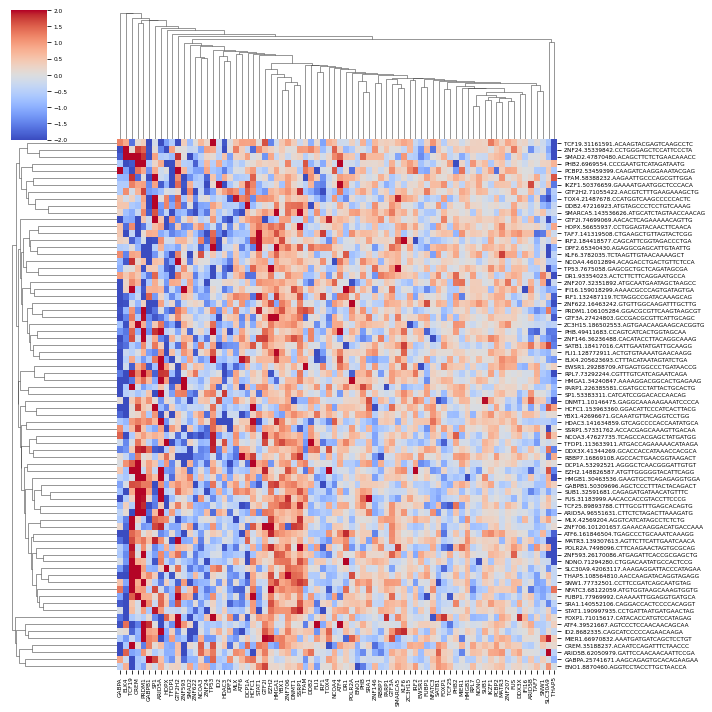

In [57]:
sns.clustermap(-1*heatmap, vmax=2, vmin=-2,xticklabels=1, yticklabels=1, center=0, cmap='coolwarm', z_score=0)

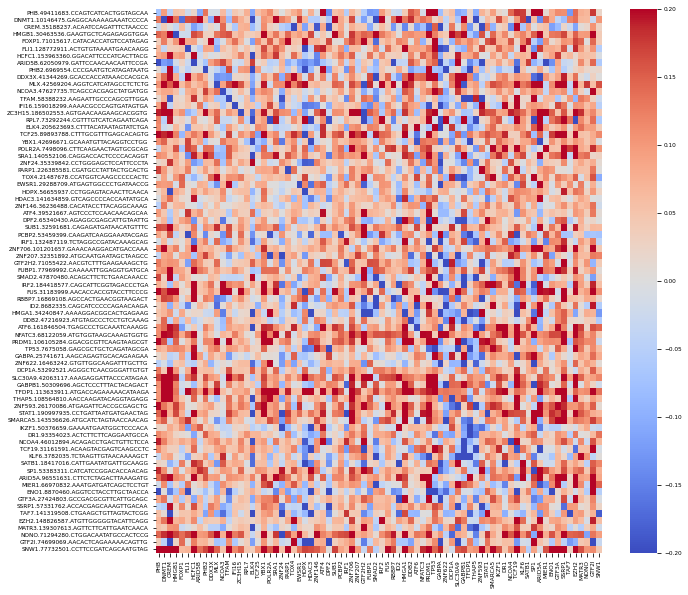

In [58]:
plt.figure(figsize=(10,10))
sns.heatmap(-1*heatmap, vmax=0.2, vmin=-0.2,xticklabels=1, yticklabels=1, center=0, cmap='coolwarm')
plt.savefig('targets.png', dpi=300)